## Example of how to apply a ML model to IRAC data

#### This code applies a model for removing systematics to exoplanet light curve data from the Spitzer IRAC archive and plots some results. 

The method to make the model is described in detail in Krick et al. 2020. Briefly, we used scikitlearn xgboost to learn a model using features based on past experience with systematics removal.  We used a calibration dataset from a star which is known to not vary astrophysically.  The science data is 10 observations of eclipses of XO3b taken from the Spitzer archive and also discussed in Wong et al. 2015 and Ingalls et al. 2016.  

We generated the XO3 photometry csv file using the idl code phot_exoplanet_csv.pro.  It is important that the data features be generated in the same way for the science data as was done when generating the model.


In [1]:
import batman
import exoparams
import numpy as np
import statistics
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from batman             import TransitParams, TransitModel
from functools          import partial
from lmfit              import Minimizer, Parameters, report_errors
from pylab              import *;ion()
from scipy              import stats
from sklearn.externals import joblib
from astropy.stats      import sigma_clip

dirname = '/Users/jkrick/Library/Mobile Documents/com~apple~CloudDocs/XO3/'

#Here are the names of the 10 observations of XO3b
aorname = ['r46468096','r46468352','r46468608','r46469120','r46469632','r46470400',
           'r46470656','r46470912','r46471168','r46471424']
n_aor = 10 
#data
e_depth = np.zeros(n_aor)  #waiting for eclipse depths
deptherr = np.zeros(n_aor)  #waiting for uncertainties on eclipse depths

#model to be used to correct the data
model_name='xgboost_PLD_sumnorm_mse_ch2.pkl'


#set the planetname for finding initial guesses of planet parameters
planetname = 'XO-3 b'



In [2]:
#These functions set up transit fitting with Batman
def deltaphase_eclipse(ecc, omega, omegatype = 'RV'):
    from numpy import cos, pi, abs
    return 0.5*( 1 + (4. / pi) * ecc * cos(omega))

def batman_lmfit_model(period, tCenter, inc, aprs, edepth, tdepth, ecc, omega, times,u1=None, u2=None,
                       ldtype = 'uniform', transittype="secondary", bm_params=None):
    if tdepth is not 0.0 or edepth is not 0.0:
        if bm_params is None:
            bm_params = TransitParams() # object to store transit parameters
        
        bm_params.per       = period  # orbital period
        bm_params.t0        = tCenter # time of inferior conjunction
        bm_params.a         = aprs    # semi-major axis (in units of stellar radii)
        bm_params.fp        = edepth  # f
        bm_params.tdepth    = tdepth  # from Fraine et al. 2014s
        bm_params.rp        = math.sqrt(tdepth) # planet radius (in units of stellar radii)
        bm_params.ecc       = ecc     # eccentricity
        bm_params.w         = omega   # longitude of periastron (in degrees)
        bm_params.inc       = inc     # orbital inclination (in degrees)
        bm_params.limb_dark = ldtype  # limb darkening model # NEED TO FIX THIS
        bm_params.u         = []      # limb darkening coefficients # NEED TO FIX THIS
        
        
        if u1 is not None and ldtype is not 'uniform':
            bm_params.u.append(u1)
        elif u1 is not None and ldtype is 'uniform':
            raise ValueError('If you set `u1`, you must also set `ldtype` to either linear or quadratic')
        if u2 is not None and ldtype is 'quadratic':
            bm_params.u.append(u2)
        elif u2 is not None and ldtype is not 'quadratic':
            raise ValueError('If you set `u2`, you must also set `ldtype` quadratic')
        
        if transittype=="secondary" and edepth != 0.0:
            bm_params.delta_phase = deltaphase_eclipse(bm_params.ecc, bm_params.w) if bm_params.ecc is not 0.0 else 0.5
            bm_params.t_secondary = bm_params.t0 + bm_params.per*bm_params.delta_phase

        m_eclipse = TransitModel(bm_params, times, transittype=transittype).light_curve(bm_params)
    else:
        return ones(times.size)
    
    return m_eclipse

def residuals_func(model_params, times, data, data_err, ldtype='uniform'):

    """Returns residuals of current model estimate with input `data`
    
    Args:
        model_params    : set of model parmaeters  -- named to avoid global / local confusion
        data            : data to be fit
        times           : temporal array to use with model
        input_features  : basis vectors for linear fitting to noise array
        in_eclipse      : boolean array to identify the eclipse location from initial guess
        method          : string to identify if residuals should be taken over 
                            `fourier` or `spiderman` phase curve models
    
    Returns:
        Returns the array of residuals, that is the data - model
    """
    # Return residuals between this model and the `data` allocated above
    period  = model_params['period']
    tCenter = model_params['tCenter']
    inc     = model_params['inc']
    aprs    = model_params['aprs']
    edepth  = model_params['edepth']
    tdepth  = model_params['tdepth']
    ecc     = model_params['ecc']
    omega   = model_params['omega']
#    u1      = model_params['u1']
#    u2      = model_params['u2']
    intcpt  = model_params['intcpt']
    slope   = model_params['slope']
    crvtur  = model_params['crvtur']
   
    model_now = batman_lmfit_model(period, tCenter, inc, aprs, edepth, tdepth, ecc, omega, times,
                                    ldtype=ldtype)#u1=u1, u2=u2,
    
    line_model  = intcpt
    if slope != 0:
        line_model += slope*(times - times.mean())
    if crvtur != 0:
        line_model += crvtur*(times - times.mean())**2
    
    model_total = model_now*line_model
    
    return ((model_total - data) / data_err)**2

def exoparams_to_lmfit_params(planet_name):
    ep_params   = exoparams.PlanetParams(planet_name)
    iApRs       = ep_params.ar.value
    iEcc        = ep_params.ecc.value
    iInc        = ep_params.i.value
    iPeriod     = ep_params.per.value
    iTCenter    = ep_params.tt.value
    iTdepth     = ep_params.depth.value
    iOmega      = ep_params.om.value
    
    return iApRs, iEcc, iInc, iPeriod, iTCenter, iTdepth, iOmega

def exoparams_to_batman_model(planet_name, times=None, u1=None, u2=None):
    ep_params           = exoparams.PlanetParams(planet_name)
    bm_params           = TransitParams()

    bm_params.a         = ep_params.ar.value
    bm_params.ecc       = ep_params.ecc.value
    bm_params.inc       = ep_params.i.value
    bm_params.limb_dark = 'uniform'
    bm_params.per       = ep_params.per.value
    bm_params.t0        = ep_params.tt.value
    bm_params.rp        = math.sqrt(ep_params.depth.value)
    bm_params.w         = ep_params.om.value
    
    ldcs  = []
    if u1 is not None:
        bm_params.limb_dark = 'linear'
        ldcs.append(u1)
        if u2 is not None:
            bm_params.limb_dark = 'quadratic'
            ldcs.append(u2)    
    
    bm_params.u         = ldcs
    if times is not None:
        times = times.copy()
        if len(str(times[0]).split('.')[0]) == 5:
            times += 2400000
        if len(str(times[0]).split('.')[0]) == 4:
            times += 2450000
        
        lc_model  = TransitModel(bm_params, times).light_curve(bm_params)
        
        return lc_model, bm_params, ep_params
    else:
        return bm_params, ep_params



In [3]:
#define my own scoring function based on accuracy of measuring transit depths
#this was used in generating the pkl model and so is needed here.
def inject_accuracy_score(estimator, X, y):

    #split up the test arrays into simulated 'AORs'
    n = 50

    #maybe don't need to inject and fit all of them
    n_aor = 31

    nr = X.shape[0]
    ns = nr/n
    dfs_X = np.array_split(X,50 , axis = 0)
    dfs_y = np.array_split(y,50 , axis = 0)
    t_depth = np.zeros(n_aor)  #waiting for transit depths
    inject_depth = np.zeros(n_aor)
    for counter in range(0, n_aor ): 
    
        #seperate pmap dataframe into a shorter df with a single AOR in it.
        df_AOR_X = dfs_X[counter]
        df_AOR_y = dfs_y[counter]
        
        #makeup a time array here
        #want it to have equally spaced times from 0 to 0.6
        pmap_time = np.linspace(0.1, 0.7, df_AOR_X.shape[0])
    
        #inject transits in that single AOR pmap data
        planet_period = 0.6   #in days .02 if pnap_time in days
        planet_sma = 0.1
        #make this a random number between 0.05 and 0.1
        rp_rs = np.random.uniform(0.03, 0.1)
        df_AOR_X_transit, inject_depth[counter] = inject_transit(rp_rs, df_AOR_X, df_AOR_y, 
                                                                 pmap_time, planet_period, planet_sma, verbose=True)

        #apply ML correction to injected data
        y_data_predict = apply_ML(df_AOR_X_transit, estimator)


        #measure the depth of the transit injected in previous step
        t_depth[counter], fitresults_lmfit = measure_transit_depth(y_data_predict, pmap_time,planet_period, rp_rs )       
    
    #calcaulate accuracy on ensemble of AORs
    a = accuracy(t_depth, inject_depth, np.median(df['flux']))
    
    return a


In [4]:
## set up parameters for fitting the XO3 data
#get initial guesses at planet parameters from exoplanet.org
iApRs, iEcc, iInc, iPeriod, iTCenter, iTdepth, iOmega = exoparams_to_lmfit_params(planetname)

#make an educated guess for the initial and minimum eclipse depth and argument of periastron
iEdepth = 0.0015 
iEdepth_min = 0.0011 
iOmega = 346
#do not fit limb darkening parameters
u1 = None
u2 = None

#only fitting eclipse depth and out of transit intercept, slope and curvature
init_params_lmfit = Parameters()
init_params_lmfit.add_many(
    # Planetary Parameters
    ('period' , iPeriod , False),
    ('tCenter', iTCenter, False , iTCenter-1.5, iTCenter+1.5), # +\- 1.2 hours
    ('inc'    , iInc    , False, 75.0 ,  90.), # Physically down to 0.0, but 80.0 is already an 'extreme' value
    ('aprs'   , iApRs   , False,  0.0 , 100.), # 100.0 is considered "very large" for transiting exoplanets; but could go up to np.inf
    ('edepth' , iEdepth , True,  iEdepth_min , 0.005 ), # 1.0   is considered "very large" for transiting exoplanets -- could go down to 0.1
    ('tdepth' , iTdepth , False,  0.0 , 0.01 ), # 1.0   is considered "very large" for transiting exoplanets -- could go down to 0.25 
    ('ecc'    , iEcc    , False,  0.1 , 0.5 ), # 1.0   is considered "very large" for transiting exoplanets -- could go down to 0.5
    ('omega'  , iOmega  , False,  345 , 347), # Could be any number around a circle; but prescribing to "near RV results" is probably best
    ('u1'     , u1      , False,  0.0 , 1.0 ), # could go up to 1; but physically, u1 + u2 < 1.0; so u1 and u2 cannot both be 1.0
    ('u2'     , u2      , False,  0.0 , 1.0 ), # could go up to 1; but physically, u1 + u2 < 1.0; so u1 and u2 cannot both be 1.0

    # Out of transit linear baselines
    ('intcpt' , 1.0 , True, 0.95, 1.05 ),  # If the 'linear model' is centered around the median(time), then 1.0 should be a useful initial condition
    ('slope'  , 0.0 , True, -0.009, 0.015),   # If the 'linear model' is centered around the median(time), then 0.0 should be a useful initial condition
    ('crvtur' , -0.03 , True, -0.08, 0.00))  # If the 'linear model' is centered around the median(time), then 0.0 should be a useful initial condition



### For each of the observations, read in the features, do some feature engineering in the same way as was done to generate the model, then use the model to predict fluxes, and correct the data with those fluxes.  Lastly, make a plot with raw and corrected fluxes for visual comparison



/Users/jkrick/anaconda/lib/python3.5/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 0.20rc1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a d

Name        Value      Min      Max   Stderr     Vary     Expr Brute_Step
aprs        4.946        0      100        0    False     None     None
crvtur    -0.0102    -0.08        0 0.004298     True     None     None
ecc        0.2884      0.1      0.5        0    False     None     None
edepth   0.001607   0.0011    0.005 9.103e-05     True     None     None
inc         79.32       75       90        0    False     None     None
intcpt     0.9991     0.95     1.05 5.338e-05     True     None     None
omega         346      345      347        0    False     None     None
period      3.192     -inf      inf        0    False     None     None
slope    0.0008103   -0.009    0.015 0.0002892     True     None     None
tCenter  2.454e+06 2.454e+06 2.454e+06        0    False     None     None
tdepth   0.008943        0     0.01        0    False     None     None
u1              0        0        1        0    False     None     None
u2              0        0        1        0    False  

/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Name        Value      Min      Max   Stderr     Vary     Expr Brute_Step
aprs        4.946        0      100        0    False     None     None
crvtur   -0.01476    -0.08        0 0.004521     True     None     None
ecc        0.2884      0.1      0.5        0    False     None     None
edepth   0.001447   0.0011    0.005 9.389e-05     True     None     None
inc         79.32       75       90        0    False     None     None
intcpt     0.9991     0.95     1.05 5.308e-05     True     None     None
omega         346      345      347        0    False     None     None
period      3.192     -inf      inf        0    False     None     None
slope    0.001441   -0.009    0.015 0.0002958     True     None     None
tCenter  2.454e+06 2.454e+06 2.454e+06        0    False     None     None
tdepth   0.008943        0     0.01        0    False     None     None
u1              0        0        1        0    False     None     None
u2              0        0        1        0    False   

/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Name        Value      Min      Max   Stderr     Vary     Expr Brute_Step
aprs        4.946        0      100        0    False     None     None
crvtur   -0.002828    -0.08        0 0.004431     True     None     None
ecc        0.2884      0.1      0.5        0    False     None     None
edepth     0.0011   0.0011    0.005  0.00339     True     None     None
inc         79.32       75       90        0    False     None     None
intcpt     0.9992     0.95     1.05 5.381e-05     True     None     None
omega         346      345      347        0    False     None     None
period      3.192     -inf      inf        0    False     None     None
slope    0.004737   -0.009    0.015 0.0002932     True     None     None
tCenter  2.454e+06 2.454e+06 2.454e+06        0    False     None     None
tdepth   0.008943        0     0.01        0    False     None     None
u1              0        0        1        0    False     None     None
u2              0        0        1        0    False   

/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Name        Value      Min      Max   Stderr     Vary     Expr Brute_Step
aprs        4.946        0      100        0    False     None     None
crvtur   -8.52e-06    -0.08        0 0.004428     True     None     None
ecc        0.2884      0.1      0.5        0    False     None     None
edepth   0.001323   0.0011    0.005 9.227e-05     True     None     None
inc         79.32       75       90        0    False     None     None
intcpt      0.999     0.95     1.05 5.245e-05     True     None     None
omega         346      345      347        0    False     None     None
period      3.192     -inf      inf        0    False     None     None
slope    0.0004175   -0.009    0.015 0.0002906     True     None     None
tCenter  2.454e+06 2.454e+06 2.454e+06        0    False     None     None
tdepth   0.008943        0     0.01        0    False     None     None
u1              0        0        1        0    False     None     None
u2              0        0        1        0    False 

/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Name        Value      Min      Max   Stderr     Vary     Expr Brute_Step
aprs        4.946        0      100        0    False     None     None
crvtur   -0.00945    -0.08        0 0.004493     True     None     None
ecc        0.2884      0.1      0.5        0    False     None     None
edepth    0.00161   0.0011    0.005 9.337e-05     True     None     None
inc         79.32       75       90        0    False     None     None
intcpt      0.999     0.95     1.05 5.166e-05     True     None     None
omega         346      345      347        0    False     None     None
period      3.192     -inf      inf        0    False     None     None
slope    0.002253   -0.009    0.015 0.0002843     True     None     None
tCenter  2.454e+06 2.454e+06 2.454e+06        0    False     None     None
tdepth   0.008943        0     0.01        0    False     None     None
u1              0        0        1        0    False     None     None
u2              0        0        1        0    False   

/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Name        Value      Min      Max   Stderr     Vary     Expr Brute_Step
aprs        4.946        0      100        0    False     None     None
crvtur   -5.354e-09    -0.08        0 0.0002802     True     None     None
ecc        0.2884      0.1      0.5        0    False     None     None
edepth   0.001418   0.0011    0.005 9.43e-05     True     None     None
inc         79.32       75       90        0    False     None     None
intcpt      0.999     0.95     1.05 5.239e-05     True     None     None
omega         346      345      347        0    False     None     None
period      3.192     -inf      inf        0    False     None     None
slope    -0.0003896   -0.009    0.015  0.00029     True     None     None
tCenter  2.454e+06 2.454e+06 2.454e+06        0    False     None     None
tdepth   0.008943        0     0.01        0    False     None     None
u1              0        0        1        0    False     None     None
u2              0        0        1        0    False

/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Name        Value      Min      Max   Stderr     Vary     Expr Brute_Step
aprs        4.946        0      100        0    False     None     None
crvtur   -1.181e-05    -0.08        0 0.004211     True     None     None
ecc        0.2884      0.1      0.5        0    False     None     None
edepth     0.0011   0.0011    0.005 0.0001583     True     None     None
inc         79.32       75       90        0    False     None     None
intcpt     0.9992     0.95     1.05 5.158e-05     True     None     None
omega         346      345      347        0    False     None     None
period      3.192     -inf      inf        0    False     None     None
slope    0.001217   -0.009    0.015 0.0002838     True     None     None
tCenter  2.454e+06 2.454e+06 2.454e+06        0    False     None     None
tdepth   0.008943        0     0.01        0    False     None     None
u1              0        0        1        0    False     None     None
u2              0        0        1        0    False 

/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Name        Value      Min      Max   Stderr     Vary     Expr Brute_Step
aprs        4.946        0      100        0    False     None     None
crvtur   -0.002256    -0.08        0 0.004335     True     None     None
ecc        0.2884      0.1      0.5        0    False     None     None
edepth     0.0015   0.0011    0.005 9.148e-05     True     None     None
inc         79.32       75       90        0    False     None     None
intcpt      0.999     0.95     1.05 5.308e-05     True     None     None
omega         346      345      347        0    False     None     None
period      3.192     -inf      inf        0    False     None     None
slope    0.002919   -0.009    0.015 0.0002914     True     None     None
tCenter  2.454e+06 2.454e+06 2.454e+06        0    False     None     None
tdepth   0.008943        0     0.01        0    False     None     None
u1              0        0        1        0    False     None     None
u2              0        0        1        0    False  

/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Name        Value      Min      Max   Stderr     Vary     Expr Brute_Step
aprs        4.946        0      100        0    False     None     None
crvtur   -0.01745    -0.08        0 0.004605     True     None     None
ecc        0.2884      0.1      0.5        0    False     None     None
edepth   0.001764   0.0011    0.005 9.416e-05     True     None     None
inc         79.32       75       90        0    False     None     None
intcpt      0.999     0.95     1.05 5.163e-05     True     None     None
omega         346      345      347        0    False     None     None
period      3.192     -inf      inf        0    False     None     None
slope    -0.0009145   -0.009    0.015 0.0002827     True     None     None
tCenter  2.454e+06 2.454e+06 2.454e+06        0    False     None     None
tdepth   0.008943        0     0.01        0    False     None     None
u1              0        0        1        0    False     None     None
u2              0        0        1        0    False 

/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/jkrick/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Name        Value      Min      Max   Stderr     Vary     Expr Brute_Step
aprs        4.946        0      100        0    False     None     None
crvtur   -0.009482    -0.08        0 0.004325     True     None     None
ecc        0.2884      0.1      0.5        0    False     None     None
edepth   0.001613   0.0011    0.005 9.138e-05     True     None     None
inc         79.32       75       90        0    False     None     None
intcpt      0.999     0.95     1.05 5.359e-05     True     None     None
omega         346      345      347        0    False     None     None
period      3.192     -inf      inf        0    False     None     None
slope    0.001407   -0.009    0.015 0.0002989     True     None     None
tCenter  2.454e+06 2.454e+06 2.454e+06        0    False     None     None
tdepth   0.008943        0     0.01        0    False     None     None
u1              0        0        1        0    False     None     None
u2              0        0        1        0    False  

NameError: name 'model' is not defined

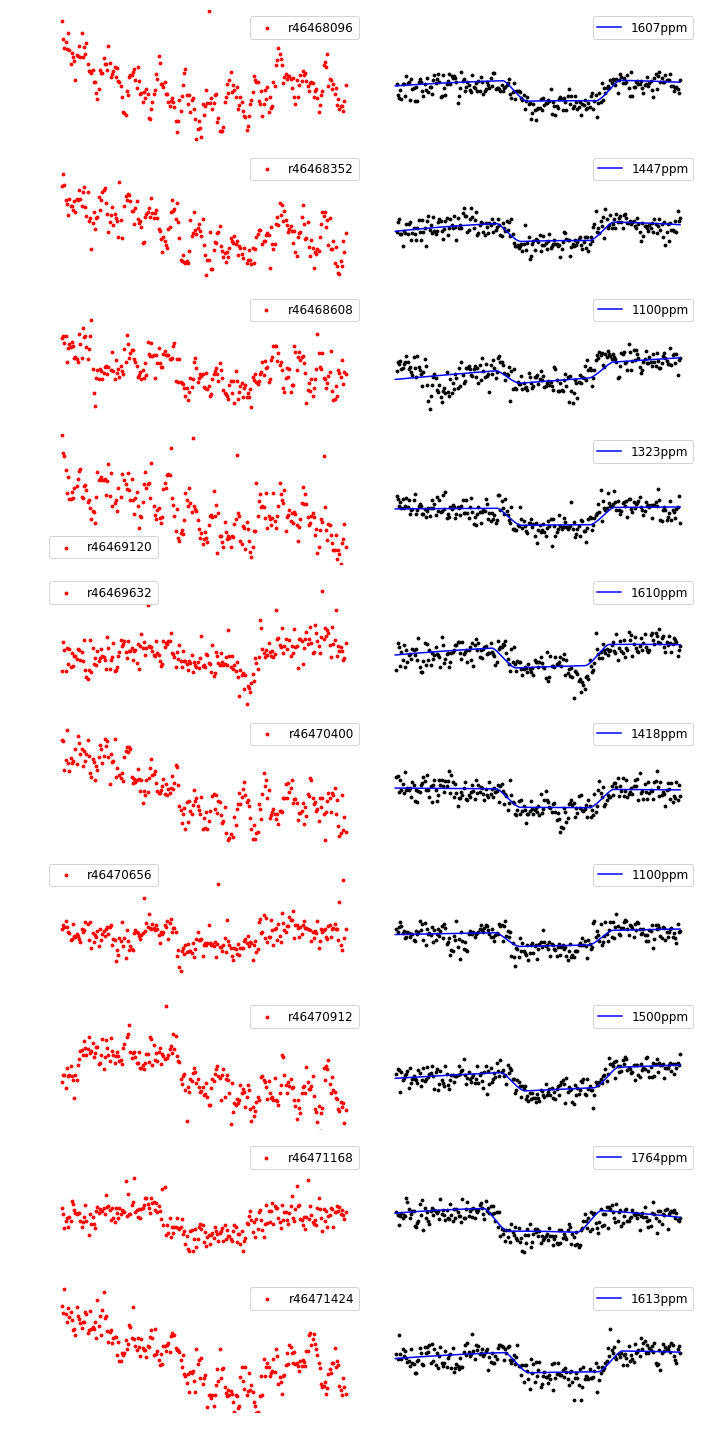

In [5]:
#load the previously trained model
xgbr = joblib.load(model_name)



#Make one big master plot with all 10 light curves on it
figfull, axfull = plt.subplots( nrows = 10, ncols = 2, sharex = True,  sharey = True, 
                               figsize = (10,20))


for counter in range(0,n_aor): #for each observation
    #load data
    csv_name = dirname + 'XO3_' + aorname[counter] + '.csv'
    XO3 = pd.read_csv(csv_name)

    #remove any row which has a nan anywhere
    XO3.dropna(inplace = True)

 
    #adjust the pixel values to be normalized by the mean of the sum of all pixel values
    XO3['pixsum'] = XO3['pix1'] + XO3['pix2'] + XO3['pix3'] + XO3['pix4'] + XO3['pix5'] + XO3['pix6']+XO3['pix7'] + XO3['pix8']+ XO3['pix9']
    medflux_XO3 = statistics.median(XO3['pixsum'])
    meanflux_XO3 = statistics.mean(XO3['pixsum'])

    XO3['pix1']/= XO3['pixsum']#meanflux_XO3#
    XO3['pix2']/= XO3['pixsum']#meanflux_XO3#
    XO3['pix3']/= XO3['pixsum']#meanflux_XO3#
    XO3['pix4']/= XO3['pixsum']#meanflux_XO3#
    XO3['pix5']/= XO3['pixsum']#meanflux_XO3#
    XO3['pix6']/= XO3['pixsum']#meanflux_XO3#
    XO3['pix7']/= XO3['pixsum']#meanflux_XO3#
    XO3['pix8']/= XO3['pixsum']#meanflux_XO3#
    XO3['pix9']/= XO3['pixsum']#meanflux_XO3#


    #normalize bg_flux in some way as well.
    meanbgflux_XO3 = statistics.mean(XO3['bg_flux'])
    XO3['bg_flux'] /= meanbgflux_XO3


    #also need to do the background errors and flux error
    meanfluxerr=statistics.mean(XO3['fluxerr'])
    meansigmabgflux = statistics.mean(XO3['sigma_bg_flux'])
    XO3['fluxerr']/= meanfluxerr
    XO3['sigma_bg_flux'] /= meansigmabgflux


    #choose feature set 
    #16 feature feature set
    #X_data = XO3[['xpos','ypos',  'fluxerr','xfwhm','yfwhm','bg_flux', 'sigma_bg_flux','pix1','pix2', 'pix3','pix4','pix5','pix6','pix7','pix8','pix9']]

    #PLD emulator - 9 feature set
    X_data = XO3[['pix1','pix2', 'pix3','pix4','pix5','pix6','pix7','pix8','pix9']]

    y_data = XO3['flux']
 
    #normalize y
    #my = statistics.median(y_data)
    #y_data = y_data / my

    time_bmjd = XO3['bmjd']
    time_0 = time_bmjd - time_bmjd[0]
    time_jd = time_bmjd + 2400000.5

    #use the trained xgboost model to correct the data (predict fluxes)
    y_data_predict = xgbr.predict(X_data)

    #predicted values are actually predicted gain so need to multiply those 
    #by the y_data to get y_predict
    y_data_predict = y_data / y_data_predict

    #do sigma clipping on flux
    filtered_data = sigma_clip(y_data_predict, sigma=3.0) 
    y_data_filtered = y_data_predict[~filtered_data.mask]
    time_jd_filtered = time_jd[~filtered_data.mask]

    #binning to get ready for plotting
    raw_means, raw_edges, raw_number = stats.binned_statistic(time_jd, y_data, statistic = 'mean', 
                                                            bins = (len(time_jd) / 63))

    #figure out what the center of the bins in time is:
    raw_time_bins = (raw_edges[:-1]+raw_edges[1:])/2
    
    #stddev in the bin
    raw_s_bins,raw_s_edges, raw_misc = stats.binned_statistic(time_jd_filtered,y_data_filtered,
                                                            statistic=np.std, bins=(len(time_jd) / 63))


    #need to bin both fluxes and time
    corr_means, corr_edges, corr_number = stats.binned_statistic(time_jd_filtered, y_data_filtered, 
                                                            statistic = 'mean', bins = (len(time_jd) / 63))

    #figure out what the center of the bins in time is:
    corr_time_bins = (corr_edges[:-1]+corr_edges[1:])/2

    #stddev in the bin
    corr_s_bins,corr_s_edges, corr_misc = stats.binned_statistic(time_jd_filtered,y_data_filtered,
                                                            statistic=np.std, bins=(len(time_jd) / 63))

    #normalize
    med_corr = statistics.median(corr_means)
    med_raw = statistics.median(raw_means)

    #run LM fitting
    partial_residuals = partial(residuals_func, data = y_data_filtered.values/median(y_data_filtered), 
                                data_err = sqrt(y_data_filtered.values / median(y_data_filtered)), times = time_jd_filtered.values)

    mean_time = mean(time_jd_filtered)

    mini = Minimizer(partial_residuals, init_params_lmfit)

    fitResults_lmfit = mini.leastsq()
    
    fitResults_lmfit.params.pretty_print()
    fitResults_lmfit.message
    
    #overplotting the results on the data
    #convert lmfit params to batman params
    lm_paramsdict = fitResults_lmfit.params.valuesdict()
    bm_lmfit_params           = TransitParams()

    bm_lmfit_params.a         = lm_paramsdict['aprs']
    bm_lmfit_params.ecc       = lm_paramsdict['ecc']
    bm_lmfit_params.inc       = lm_paramsdict['inc']
    bm_lmfit_params.limb_dark = 'uniform'
    bm_lmfit_params.per       = lm_paramsdict['period']
    bm_lmfit_params.t0        = lm_paramsdict['tCenter']
    bm_lmfit_params.rp        = sqrt(lm_paramsdict['edepth'])
    bm_lmfit_params.w         = lm_paramsdict['omega']
    bm_lmfit_params.u       = []  #right now using uniform limb darkening
    bm_lmfit_params.fp        =lm_paramsdict['edepth']

    #make the batman model with the fitted parameters
    lm_model_flux = batman_lmfit_model(lm_paramsdict['period'], lm_paramsdict['tCenter'], 
                                lm_paramsdict['inc'], lm_paramsdict['aprs'], 
                                lm_paramsdict['edepth'], lm_paramsdict['tdepth'],
                                lm_paramsdict['ecc'], lm_paramsdict['omega'], 
                                time_jd_filtered.values, ldtype='uniform')
    line_model  = lm_paramsdict['intcpt']
    if lm_paramsdict['slope'] != 0:
        line_model += lm_paramsdict['slope']*(time_jd_filtered.values - time_jd_filtered.values.mean())
    if lm_paramsdict['crvtur'] != 0:
        line_model += lm_paramsdict['crvtur']*(time_jd_filtered.values - time_jd_filtered.values.mean())**2
    
    model_total = lm_model_flux*line_model



    #plot the models
    d = max(lm_model_flux) - min(lm_model_flux)
    d = lm_paramsdict['edepth']*1E6
    depth =  "{0:.0f}".format(d) 
    depth_name = depth + 'ppm'
    print('depth name', depth_name)

    #Fill the big figure
    axfull[counter,0].scatter(raw_time_bins - raw_time_bins[-1], raw_means/med_raw, color = 'red', s = 8, label = aorname[counter] )
    axfull[counter,1].scatter(corr_time_bins - corr_time_bins[-1], corr_means/med_corr, color = 'black', s = 8)
    axfull[counter,1].plot(time_jd_filtered - time_jd_filtered.iloc[-1], model_total, color = 'blue', label = depth_name) #lm_paramsdict['edepth']
    axfull[counter,0].legend(fontsize='large')
    axfull[counter,1].legend(fontsize='large')

    #and make it look good
    axfull[counter, 0].set_ylim((0.996,1.006))
    axfull[counter, 1].set_ylim((0.996,1.006))
    figfull.subplots_adjust(hspace=0.00)
    axfull[counter, 0].axis("off")
    axfull[counter, 1].axis("off")

    #store eclipse depth for summary plot later
    e_depth[counter] = d
    deptherr[counter] = fitResults_lmfit.params['edepth'].stderr *1E6

        
plt.tight_layout()

#save
savename = dirname + 'XO3_summary_'  + model[0:-8]+ '.png'
#plt.savefig(savename)
plt.show()





XGBoost mean and std 1448.146038221669 209.81570198888275


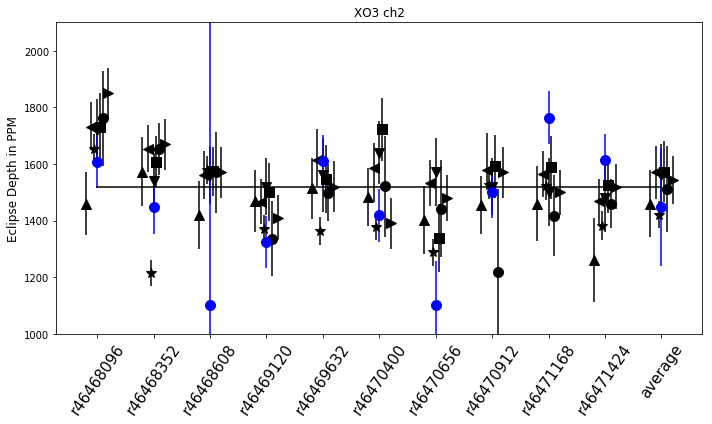

In [6]:
# Plot the eclipse depths as a function of AOR
fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize = (10,6))
ax.set_title("XO3 ch2")
     
#compare to the literature
BLISS = [1850.00, 1670.00, 1570.00, 1410.00, 1520.00, 1390.00, 1480.00, 1570.00, 1500.00, 1520.00 ,1543]
GP  =[1763.00, 1652.00, 1570.00, 1336.00, 1497.00 ,1522.00, 1441.00, 1217.00, 1415.00, 1459.00 ,1513]
ICA  =[1720.00, 1540.00, 1560.00, 1520.00, 1560.00, 1640.00, 1570.00, 1520.00, 1500.00, 1480.00 ,1560]
KR_Data  =[1732.00, 1653.00, 1561.00, 1467.00, 1614.00, 1587.00, 1533.00, 1578.00, 1565.00, 1468.00,1570 ]
KR_Pmap  =[1460.00, 1572.00, 1420.40, 1470.00, 1514.00, 1483.00, 1402.00, 1455.00, 1459.00, 1260.00,1460 ]
PLD  =[1729.00, 1608.00, 1574.00, 1500.00, 1547.00, 1723.00, 1339.00, 1592.00, 1588.00, 1525.00 ,1573]
SP_K2  =[1653.70, 1214.60, 1578.80, 1370.90, 1363.30, 1377.80, 1287.70, 1525.50, 1522.30, 1382.20,1421 ]

BLISS_unc = [   90.00,   90.00,   90.00,   80.00,   90.00 ,  90.00 ,  80.00,   90.00 ,  80.00,   80.00 ,85]
GP_unc_neg = [  169.00,   92.00,  143.00,  133.00 ,  98.00,  181.00 , 169.00,  279.00 , 142.00 ,  86.00 ,152]
GP_unc_pos = [  164.00,   93.00,  143.00,  133.00,  101.00 , 178.00 , 174.00 , 293.00 , 146.00 ,  88.00,152 ]
ICA_unc = [  110.00,  100.00,  100.00,  100.00,  130.00 , 110.00,  120.00 , 100.00 , 120.00,  120.00 ,111]
KR_Data_unc_neg = [ 84.00,   83.00,   84.00,   80.00,   91.00,  120.00 ,  83.00 ,  61.00 ,  81.00 ,  82.00,94 ]
KR_Data_unc_pos = [  85.00,   84.00,   85.00,   80.00,  111.00,   88.00 ,  80.00,  130.00 ,  81.00 ,  80.00,94 ]
KR_Pmap_unc = [  110.00,  121.70,  120.90,  109.00 , 108.00,  102.00 , 120.40 , 104.00,  132.00,  149.00 ,117]
PLD_unc = [  123.00,   91.00,   87.00,  102.00 , 121.00,  111.00,  121.00 , 111.00,  111.00,  100.00 ,107]
SP_K2_unc = [   52.22,   45.43,   50.38,   47.38 ,  48.37,   48.32,   47.78,   49.34 ,  49.42 ,  49.76,48 ]


ax.errorbar(np.arange(len(BLISS)) + 0.2, BLISS, yerr = BLISS_unc, fmt = 'o',  markersize = 10, color="black", marker = '>')
ax.errorbar(np.arange(len(BLISS))+0.1, GP, yerr = [GP_unc_neg, GP_unc_pos], fmt='o', markersize='10', color="black")
ax.errorbar(np.arange(len(BLISS)), ICA, yerr = ICA_unc, fmt='o', markersize='10', color="black", marker = 'v')
ax.errorbar(np.arange(len(BLISS))-.1, KR_Data, yerr = [KR_Data_unc_neg,KR_Data_unc_pos] , fmt='o', markersize='10', color="black", marker = '<')
ax.errorbar(np.arange(len(BLISS))-0.2, KR_Pmap, yerr = KR_Pmap_unc, fmt='o', markersize='10', color="black", marker = '^')
ax.errorbar(np.arange(len(BLISS))+0.05, PLD, yerr = PLD_unc, fmt='o', markersize='10', color="black", marker = 's')
ax.errorbar(np.arange(len(BLISS))-0.05, SP_K2, yerr = SP_K2_unc, fmt='o', markersize='10', color="black", marker = '*')

#xgboost results
ax.errorbar(range(len(BLISS)), np.append(e_depth, e_depth.mean()), 
            yerr = np.append(deptherr, e_depth.std()), fmt='o', 
            markersize='10', color="blue", label = 'xgboost_mse')



ax.set_xticks(range(len(BLISS)))
ax.set_xticklabels(np.append(aorname,'average'), fontsize = 15, rotation=55)


#add average of all other methods
average = np.zeros(len(BLISS)) + 1520.
ax.plot(range(len(BLISS)), average, color = 'black')
print('XGBoost mean and std', e_depth.mean(), e_depth.std())


ax.set_ylabel('Eclipse Depth in PPM', fontsize = 'large')
ax.set_ylim(1000, 2100)

plt.tight_layout()
#save
savename = dirname + 'XO3_ML_xgboost.png'
#plt.savefig(savename, edgecolor = 'white')


plt.show()